# NEXRAD AWS QVP Code

This code downloads all radar data for a given set of WSR-88D radars between a start and end time, saves them to a chosen directory, and creates QVPs of reflectivity, cross-correlation coefficient, differential phase, and differential reflectivity as well as the vertical gradients and azimuthal variance of each.

In [1]:
%%capture
import warnings
warnings.filterwarnings("ignore")
#HRRR Directory must be placed in working directory with title format 'HRRR 2020-01-01' to be read in 
import nexradaws
import shutil
import datetime as dt
import contextlib
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cg
import pyart
from metpy.plots import USCOUNTIES
import os 
import numpy as np
import xarray as xr
import pandas as pd
import logging
from imp import reload
import traceback
from collections import Counter
import pickle
import glob
from statsmodels import robust
import matplotlib.colors as mcolors
import netCDF4
from netCDF4 import Dataset
import sys
import seaborn as sns

mpl.rcParams['figure.facecolor'] = 'white'

%config InlineBackend.figure_format='retina' #Make figures high definition so they can be dragged into powerpoint without  saving them

START = dt.datetime(2020,2,7,7,0)
END = dt.datetime(2020,2,7,23,0)
EVENT_DATE = ' ' + str(START)[:-9]

RELEVANT_RADAR_IDS = ['KENX'] #change this to the radars of interest
LAT_LONGS = [(42.58639,-74.06444)]
PATH = "/Users/Gavin/Projects/Radar Meteorology/NEXRAD Scans/" #the highest level directory for saving the files, logs, and figures
DESIRED_ANGLES = [4,5] #Change this to the angle(s) of interest
THRESHOLD = .7 #Minimum Percentage of scans over the interval that contain an angle of interest. If less than this, no QVP will be generated
RELATIVE_ERROR_TOLERANCE = .25 #Maximum relative error between desired angle and the closest angle in the dataset. No QVP will be generated if relative error is greater. Set this higher to generate more QVPs

#Radars in the Northeast, United States
NE_Radars = [['KCLE', 'inland', 'Cleaveland', 'OH'],
             ['KRLX', 'inland', 'Charleston', 'WV'],
             ['KFCX', 'inland', 'Blacksburg', 'VA'],
             ['KLWX', 'inland', 'Sterling', 'VA'],
             ['KAKQ', 'coastal', 'Wakefield', 'VA'],
             ['KDOX', 'coastal', 'Dover', 'DE'],
             ['KDIX', 'coastal', 'Philadelphia', 'PA'],
             ['KPBZ', 'inland', 'Pittsburgh', 'PA'],
             ['KCCX', 'inland', 'State College', 'PA'],
             ['KBGM', 'inland', 'Binghamton', 'NY', (42.19972,-75.985)],
             ['KBUF', 'inland', 'Buffalo', 'NY',(42.94861,-78.73694)],
             ['KTYX', 'inland', 'Montague', 'NY',(43.75583,-75.68)],
             ['KENX', 'inland', 'Albany', 'NY',(42.58639,-74.06444)],
             ['KOKX', 'coastal', 'New York City', 'NY'],
             ['KBOX', 'coastal', 'Boston', 'MA'],
             ['KCXX', 'inland', 'Burlington', 'VT'],
             ['KGYX', 'coastal', 'Portland', 'ME'],
             ['KCBW', 'inland', 'Caribou', 'ME']]


In [2]:


tds_read_in = Dataset('/Users/gavin/Projects/Radar Meteorology/Data/IMPACTS_2DSH-P3_20200207_sizedistributions_v01.nc')
p3_read_in = pd.read_csv('/Users/Gavin/Projects/Radar Meteorology/Data/IMPACTS 20200207 P3 Data.txt')
display(p3_read_in.head())

tds_lat = tds_read_in['LAT'][:]
tds_lon = tds_read_in['LON'][:]
tds_alt = tds_read_in['GALT'][:]
tds_time = np.array(netCDF4.num2date(tds_read_in['time'][:], units = 'seconds since 2020-02-07 00:00:00'), dtype = 'datetime64[s]')
tds_nt = tds_read_in['NT'][:]/1000

tds_nt[tds_nt == 0] = np.nan
tds_nt[tds_nt < -998.0] = np.nan

tds_nt = tds_nt*10**-6

p3_flight_times = [['2020-02-07 15:08:00', '2020-02-07 15:22:05', 1],
                   ['2020-02-07 15:30:10', '2020-02-07 15:48:35', 2],
                   ['2020-02-07 15:58:00', '2020-02-07 16:12:55', 3],
                   ['2020-02-07 16:21:15', '2020-02-07 16:43:05', 4],
                   ['2020-02-07 16:49:50', '2020-02-07 17:17:35', 5],
                   ['2020-02-07 17:26:00', '2020-02-07 17:52:15', 6],
                   ['2020-02-07 17:59:30', '2020-02-07 18:20:10', 7]]


midnight_str = '2020-02-07 00:00:00'
midnight = dt.datetime.strptime(midnight_str, '%Y-%m-%d %H:%M:%S')
print(type(midnight))

flight_leg_altitudes = []
flight_leg_date_ranges = []
flight_leg_nt = []
flight_leg_times = []
flight_leg_lons_lats_start = []                   
flight_leg_lons_lats_end = []
flight_leg_lons = []
flight_leg_lats = []
flight_leg_temps = []
flight_leg_seconds = []
flight_leg_minutes = []

p3_times = []
print(p3_read_in['Time_Start'][0:10])
for time in p3_read_in['Time_Start']:
    td = dt.timedelta(seconds=time)
    p3_times.append(midnight + td)

p3_times = pd.DatetimeIndex(p3_times)

for i in range(len(p3_flight_times)): 
    st = p3_flight_times[i][0]
    et = p3_flight_times[i][1]
    start_idx = np.where(tds_time == np.datetime64(st))[0][0]

    end_idx = np.where(tds_time==np.datetime64(et))[0][0]
    start_lon_lat = (tds_lon[start_idx],tds_lat[start_idx])
    end_lon_lat = (tds_lon[end_idx],tds_lat[end_idx])
    flight_leg_lons_lats_start.append(start_lon_lat)                  
    flight_leg_lons_lats_end.append(end_lon_lat)
    
    
    index_time_subset = np.where((tds_time > np.datetime64(st)) & (tds_time < np.datetime64(et)))[0]
    
    lons = tds_lon[index_time_subset]
    lats = tds_lat[index_time_subset]
    flight_leg_lons.append(lons)
    flight_leg_lats.append(lats)
    altitudes = tds_alt[index_time_subset]
    flight_leg_altitudes.append(altitudes)
    times = tds_time[index_time_subset]
    flight_leg_times.append(times)
    date_range = pd.date_range(start=st,end=et,periods=len(altitudes))
    flight_leg_date_ranges.append(date_range)
    nt = tds_nt[index_time_subset]
    flight_leg_nt.append(nt)
    
for flight_leg_date_range in flight_leg_date_ranges:
    seconds_since_midnight = []
    minutes_since_midnight = []
    for time in flight_leg_date_range:
        #print(type(time))
        #print((time-midnight).seconds,time)
        seconds_since_midnight.append((time-midnight).seconds)
        #minutes_since_midnight.append((time-midnight).minutes)
    flight_leg_seconds.append(seconds_since_midnight)
    #flight_leg_minutes.append(minutes_since_midnight)

#print(flight_leg_minutes[0])
#print(flight_leg_seconds[0])  
flight_leg_altitudes = np.array(flight_leg_altitudes)/1000

,Time_Start,Day_Of_Year,Latitude,Longitude,GPS_Altitude,Pressure_Altitude,Radar_Altitude,Ground_Speed,True_Air_Speed,Indicated_Air_Speed,...,V,Solar_Zenith_Angle,Aircraft_Sun_Elevation,Sun_Azimuth,Aircraft_Sun_Azimuth,Mixing_Ratio,Part_Press_Water_Vapor,Sat_Vapor_Press_H2O,Sat_Vapor_Press_Ice,Relative_Humiditytemp
0,50747,38,37.945688,-75.456180,10.8,814,1.4,2.45,-8888.0,-8888.0,...,-9999.0,69.6,21.1,130.4,-14.3,9.45,14.72,17.60,20.42,83.64
1,50748,38,37.945672,-75.456159,10.8,812,-9999.0,2.55,-8888.0,-8888.0,...,-9999.0,69.6,20.9,130.4,-24.2,9.43,14.70,17.55,20.36,83.72
2,50749,38,37.945654,-75.456142,10.8,811,0.0,2.54,-8888.0,-8888.0,...,-9999.0,69.6,20.9,130.4,-34.4,9.42,14.67,17.38,20.13,84.43
3,50750,38,37.945634,-75.456129,10.8,810,0.8,2.51,-8888.0,-8888.0,...,-9999.0,69.6,20.7,130.4,-44.4,9.40,14.65,17.28,20.00,84.78
4,50751,38,37.945611,-75.456121,10.8,815,0.3,2.54,-8888.0,-8888.0,...,-9999.0,69.6,20.6,130.4,-54.0,9.39,14.63,17.15,19.83,85.32


<class 'datetime.datetime'>
0    50747
1    50748
2    50749
3    50750
4    50751
5    50752
6    50753
7    50754
8    50755
9    50756
Name: Time_Start, dtype: int64


In [3]:
#%%capture
figpath = '/Users/Gavin/Projects/Radar Meteorology/Microphysics Figures/2DS/'

for i in range(len(p3_flight_times)):
    plt.figure(figsize=(20,10))
    
    first_p3_time = np.argmin(abs(p3_times - flight_leg_date_ranges[i][0]))
    last_p3_time = np.argmin(abs(p3_times - flight_leg_date_ranges[i][-1]))
    
    
    data = pd.DataFrame({'nt' : flight_leg_nt[i]},index = flight_leg_date_ranges[i])
    xticks = pd.unique(data.index.round("min"))
    xticks=pd.DatetimeIndex(xticks)
    print(xticks.days)
    ax = data.groupby(lambda x: x.strftime("%H:%M")).boxplot(subplots=False,return_type="axes",positions=xticks)
    
    #xticks = pd.DataFrame(data.index).resample("%H:%M")
    
    print(xticks)
    ax.set_xticks(xticks)
    labels = [item.get_text()[1:6] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels) 
    #\ax.set_title('NT Versus Time - Flight Leg '+str(i))

    #plt.savefig(figpath + 'FlightLeg' + str(i) + '_box', dpi = 500)
    #plt.close()
    plt.show()

    data = pd.DataFrame({'nt':flight_leg_nt[i], 'time':flight_leg_date_ranges[i]})
    data.time = data.time.dt.strftime("%H:%M")
    plt.figure(figsize=(20,10))
    sns.lineplot(x="time", y="nt",err_style="band", ci='sd', estimator="median", data=data)
    plt.gca().set_title('NT Versus Time - Flight Leg '+str(i))
    #plt.savefig(figpath + 'FlightLeg' + str(i) + '_line', dpi = 500)
    #plt.close()
    plt.show()

AttributeError: 'DatetimeIndex' object has no attribute 'days'

<Figure size 1440x720 with 0 Axes>

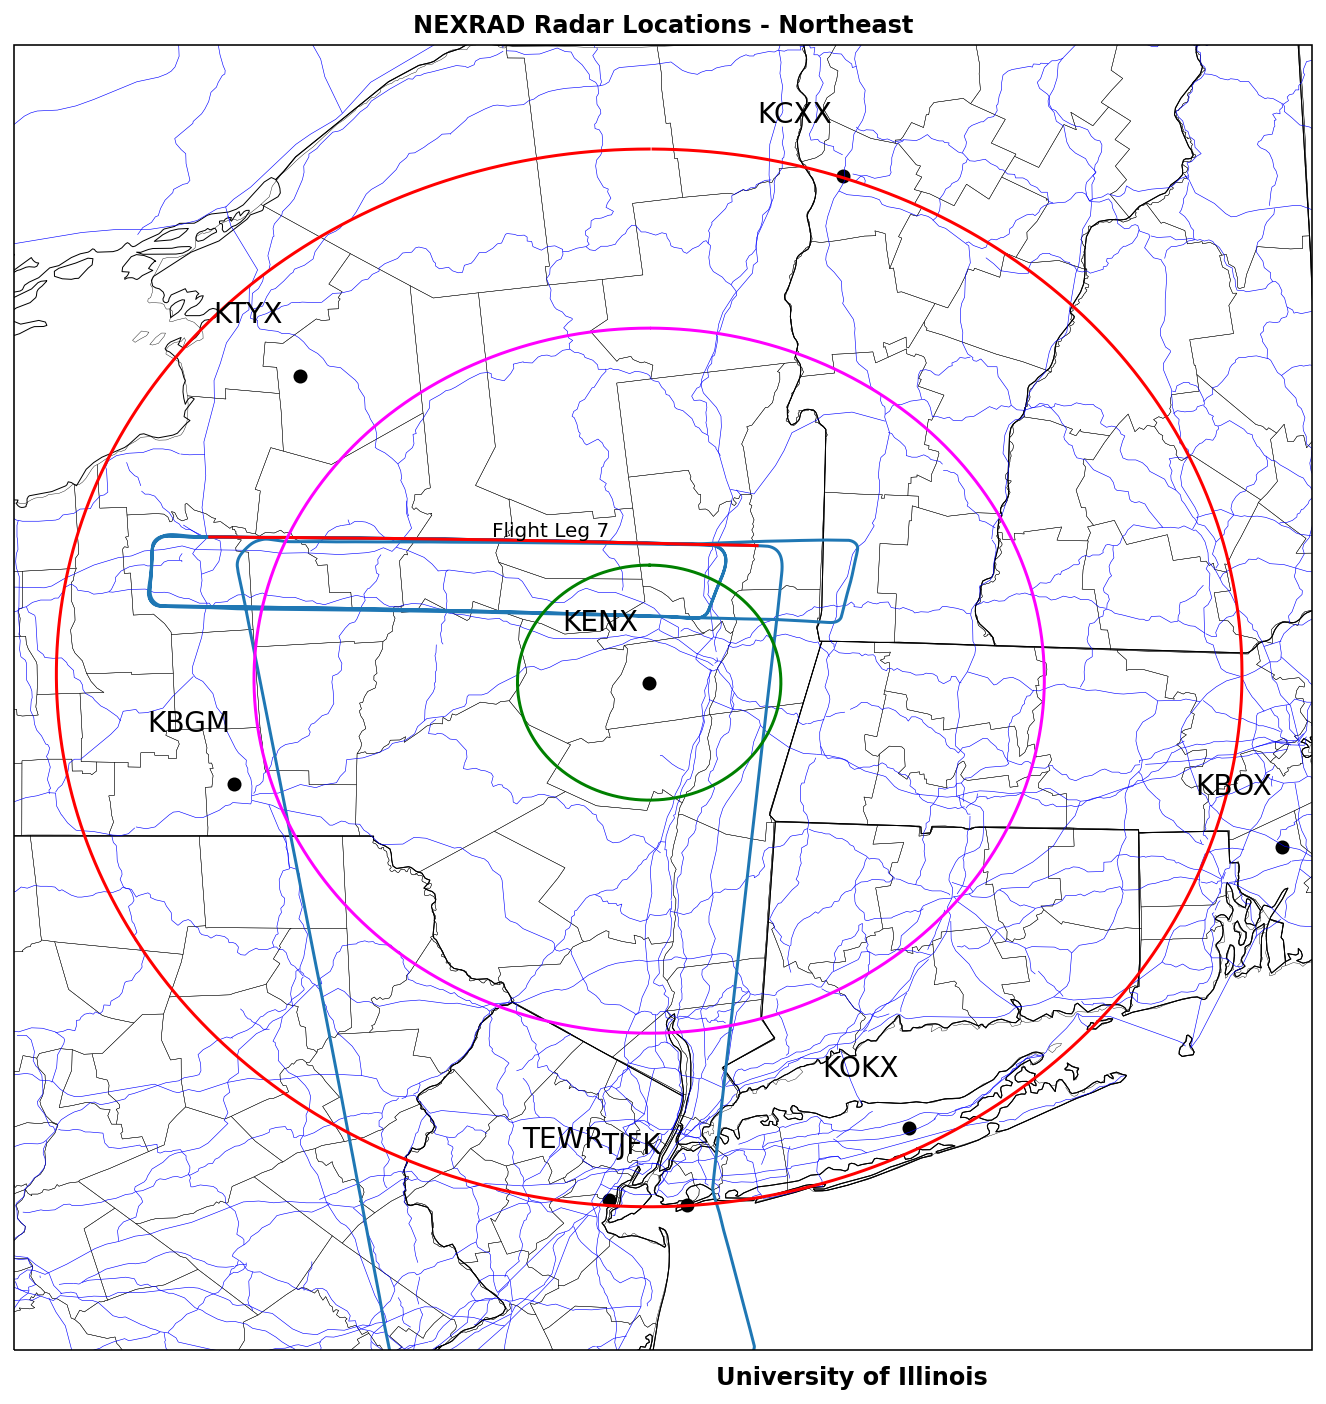

In [468]:
#makes a map of all radar locations available to us througout the northeast

locs = pyart.io.nexrad_common.NEXRAD_LOCATIONS
fig = plt.figure(figsize=(15, 12))
proj = ccrs.Miller()
ax = fig.add_subplot(1, 1, 1, projection=proj)
extent = [-77, -71, 40, 45]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5)
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
roads = cfeature.NaturalEarthFeature(category='cultural', name='roads', scale='10m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.2)
ax.add_feature(roads, edgecolor='blue', linewidth=0.3)
plt.title('NEXRAD Radar Locations - Northeast', fontweight='bold')

for key in locs:
    
    lon = locs[key]['lon']
    lat = locs[key]['lat']
    name = key
    ax.scatter(lon,lat,marker='o', color='black', transform=ccrs.PlateCarree())
    lat_mod = lat + .2
    lon_mod = lon - .4

    if lon >= extent[0] and lon <= extent[1] and lat >= extent[2] and lat <= extent[3]:
        ax.text(lon_mod, lat_mod, name, color='black', fontsize=14, transform=ccrs.PlateCarree())
ax.plot(tds_lon,tds_lat,transform=ccrs.PlateCarree())



#for i in range(len(flight_leg_lons_lats_start)):
lons = flight_leg_lons[6]
lats = flight_leg_lats[6]
ax.plot(lons,lats,transform=ccrs.PlateCarree(),color='red')
plt.text(lons[len(lons)//2],lats[len(lats)//2]+.01,'Flight Leg 7',transform = ccrs.PlateCarree())


circle_points = cg.Geodesic().circle(lon=-74.06444, lat=42.58639, radius=225*1000, n_samples=1000, endpoint=False)
ax.plot(circle_points[:,0],circle_points[:,1],transform=ccrs.PlateCarree(),color='red')

circle_points = cg.Geodesic().circle(lon=-74.06444, lat=42.58639, radius=150*1000, n_samples=1000, endpoint=False)
ax.plot(circle_points[:,0],circle_points[:,1],transform=ccrs.PlateCarree(),color='magenta')

circle_points = cg.Geodesic().circle(lon=-74.06444, lat=42.58639, radius=50*1000, n_samples=1000, endpoint=False)
ax.plot(circle_points[:,0],circle_points[:,1],transform=ccrs.PlateCarree(),color='green')
plt.savefig('/Users/Gavin/Projects/Radar Meteorology/Flight Illustration Leg 7',dpi=500)


Data we download employs nine Volume Coverage Patterns (VCPs) to adequately sample the atmosphere based on weather conditions.
A VCP is a series of 360 degree sweeps of the antenna at pre-determined elevation angles and pulse repetition frequencies completed in a specified period of time.
The radar scan times 4.5, 5, 6 or 10 minutesdepending on the selected VCP. The NEXRAD products are divided into multiple data processing levels.
The lower Level II data contain the three meteorological base data quantities at original resolution: reflectivity, mean radial velocity, and spectrum width.
With the advent of dual polarization beginning in 2011, additional base products of differential reflectivity, correlation coefficient and differential phase are available.
Mdm files are provided at the top of the hour. I believe these are summary files of the last hour. 

In [433]:
%%time
# Tries to read in already present scan data. If the data is not present, download the files

relevantFiles = {}

for ID in RELEVANT_RADAR_IDS:
    
    radarPath = PATH+ID+EVENT_DATE
    
    try:
        
        files = os.listdir(radarPath)
        files.sort()
        relevantFiles[ID] = [radarPath + '/' + file for file in files if 'MDM' not in file and '.' not in file and ID in file] #remove MDM and any other files
        
    except:
        
        conn = nexradaws.NexradAwsInterface()
        scans = conn.get_avail_scans_in_range(START, END, ID)

        with contextlib.redirect_stdout(None):
            results = conn.download(scans, radarPath) #Downloads all level 2 scans.
            
        files = os.listdir(radarPath)
        files.sort()
        relevantFiles[ID] = [radarPath + '/' + file for file in files if 'MDM' not in file]
        
    print("{}: There are {} scans available between {} and {}\n".format(ID, len(relevantFiles[ID]), START, END))

KENX: There are 179 scans available between 2020-02-07 07:00:00 and 2020-02-07 23:00:00

CPU times: user 1.23 ms, sys: 1.52 ms, total: 2.74 ms
Wall time: 1.72 ms


In [434]:
#parameters:
#    angles -- a 2D list of angles where each list represents a set of scan angles.
#    DESIRED_ANGLES -- a global varaible representing the angles we want to generate QVPs for
#    THRESHOLD -- The minimum percentage of scans that an angle must be present in
#    RELATIVE_ERROR_TOLERANCE -- a global variable representing the acceptable relative error between our desired angle and the chosen angle
#Returns a list of the angles that are closest to the DESIRED_ANGLES. Angles must be present in at least THRESHOLD percent of the scans throughout the interval.
#It will choose the angle that has the lowest relative error that is below RELATIVE_ERROR_TOLERANCE.
#Appends None if no such angle exists

def find_closest_angles(angles, DESIRED_ANGLES, THRESHOLD, RELATIVE_ERROR_TOLERANCE):
    
    closestAngles = []
    
    for desiredAngle in DESIRED_ANGLES:
        
        argmins = []
        argvals = []


        for angleList in angles:

            argmins.append(abs(np.array(angleList) - desiredAngle).argmin())
            argvals.append(angleList[argmins[-1]])

        valCounts = Counter(argvals)
        uniqueVals = np.unique(argvals)
        n = len(angles)

        for val in uniqueVals:
            if valCounts[val]/n < THRESHOLD:
                uniqueVals = np.delete(uniqueVals,np.where(uniqueVals == val))

        if len(uniqueVals) == 0:
            closestAngles.append(None)
            continue

        relativeErrors = abs(desiredAngle-uniqueVals)/desiredAngle
        idx = relativeErrors.argmin()

        if relativeErrors[idx] > RELATIVE_ERROR_TOLERANCE:
            
            closestAngles.append(None)
        
            
        else:
            
            closestAngles.append(uniqueVals[idx])
    
    return closestAngles

#Returns a 2D list containing the angles of each scan over the interval for a given radar
def generate_angles(radarID,files):
    
    angles = []
    
    for file in files[radarID]:
        try:
            
            radar = pyart.io.read_nexrad_archive(file, include_fields = []) #not including the fields speeds us up .25s per file
            angles.append(radar.fixed_angle['data'].tolist())
            
        except:
            
            continue

    return angles

#Generates QVPs for a given scan (file) and desired angles
#Returns a list of QVP dictionaries consisting of level II data averaged at all heights given for each angle
def quasi_vertical_profile(filename, closestAngles, fields=None, gatefilter=None):
    
    qvps = []
    
    radar = pyart.io.read_nexrad_archive(filename)
    
    scanAngles = radar.fixed_angle['data']
    
    for closestAngle in closestAngles:
        
        if closestAngle not in scanAngles:
            
            qvps.append(None)
            
            continue
            
        qvp = {}
        
        index = np.where(scanAngles == closestAngle)[0][0]

        if fields is None: #Goes through each file and finds the fields (i.e. reflectivity, cross correlation coefficient, etc. present. )
            fields = radar.fields

        for field in fields:
            
            thisField = radar.get_field(index, field).mean(axis = 0) #for each variable (i.e. reflectivity, cross correlation coefficient) calculate the mean at all heights given.
            thisFieldStd = radar.get_field(index, field).std(axis = 0)
            #thisFieldMad = pd.DataFrame(radar.get_field(index, field)).mad(axis=0)
            thisFieldMad = robust.mad(radar.get_field(index, field),axis=0)
            
            qvp.update({field:thisField})
            qvp.update({field+'_std':thisFieldStd})
            qvp.update({field+'_mad':np.array(thisFieldStd)})

        qvp.update({'range': radar.range['data'], 'time': radar.time}) #Updates range gates distance away from the radar
        x,y,z = pyart.core.antenna_to_cartesian(qvp['range']/1000.0, 0.0, closestAngle) #Calculates range gates x,y, and height relative to distance away from the radar 
        qvp.update({'height': z})
        qvps.append(qvp)
    
    return qvps

In [437]:
%%time
#We are going to loop through each file representative of a complete cycle of scans.  We will average the data and then 
#concatenate it into a pandas dataframe named after the individual variables
#Saves all scan data to radarPath including error logs, a .txt of the scan angles and QVP Figures, Gradients and Standard Deviations
#Will not generate QVP figures if the percentage of unusable scans from a radar exceeds THRESHOLD

scanAngles = {} #Allows us to save and inspect the scan angles for each radar's scans
unusableScans = 0

#temp contours

try:
    with open(PATH + 'HRRR' + EVENT_DATE + '/Temperatures','rb') as f:
        temps_all = pickle.load(f)
    with open(PATH + 'HRRR' + EVENT_DATE + '/Gepotentials','rb') as f:
        gps_all = pickle.load(f)
    with open(PATH + 'HRRR' + EVENT_DATE + '/Times','rb') as f:
        times_all = pickle.load(f)
except:
    file_list = glob.glob(PATH + 'HRRR' + EVENT_DATE +  '/*')
    file_list = [file for file in file_list if 'idx' not in file]
    file_list.sort()

    temps_all = []
    gps_all = []
    times_all = []


    for i in range(len(file_list)): 
        
        hrrr_read_in = xr.open_dataset(file_list[i], engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})


        lats = hrrr_read_in.latitude.values
        lons = hrrr_read_in.longitude.values - 360

        temps = []
        gps = []
        times = []

        for lat_wanted,lon_wanted in LAT_LONGS:

            a = abs(lats - lat_wanted) + abs(lons - lon_wanted) 
            x, y = np.unravel_index(np.nanargmin(a), a.shape)
            temp_radar_loc = hrrr_read_in['t'].values[:, x, y] - 273.15
            gp_radar_loc = hrrr_read_in['gh'].values[:, x, y]
            t_radar_loc = np.array([hrrr_read_in.time.values] * temp_radar_loc.shape[0])


            temps.append(temp_radar_loc)
            gps.append(gp_radar_loc)
            times.append(t_radar_loc)

        temps_all.append(temps)
        gps_all.append(gps)
        times_all.append(times)

    with open(PATH + 'HRRR' + EVENT_DATE + '/Temperatures','wb') as f:
        pickle.dump(temps_all,f)
    with open(PATH + 'HRRR' + EVENT_DATE + '/Gepotentials','wb') as f:
        pickle.dump(gps_all,f)
    with open(PATH + 'HRRR' + EVENT_DATE + '/Times','wb') as f:
        pickle.dump(times_all,f)

for radarIdx,ID in enumerate(RELEVANT_RADAR_IDS):

    radarPath = PATH+ID+EVENT_DATE
    
    #see if angles have already been stored for this radar. If so, load them in. If not, generate them by reading the files. Saves a lot of time
    try:

        with open(radarPath + '/Available Angles','rb') as f:    
            scanAngles[ID] = pickle.load(f)

    except:

        scanAngles[ID] = generate_angles(ID,relevantFiles)

        with open(radarPath + '/Available Angles','wb') as f:
            pickle.dump(scanAngles[ID],f)


    closestAngles = find_closest_angles(scanAngles[ID],DESIRED_ANGLES,THRESHOLD,RELATIVE_ERROR_TOLERANCE) #find the closest angles for all the desired angles

    for idx, closestAngle in enumerate(closestAngles.copy()):

        if closestAngle == None:

            print('No suitable angle for ' + ID, 'at ' + str(DESIRED_ANGLES[idx]) + ' degrees.')
            closestAngles.remove(closestAngle)
            continue
            
            
        figurePath = radarPath + '/Figures/' + str(closestAngle)[:5]
        
        if os.path.exists(figurePath): #if figures for this angle already exists for this radar, we remove the angle to avoid redundancy
            
            closestAngles.remove(closestAngle)

        else: #Otherwise, we make the directory to place figures into
            
            os.makedirs(figurePath)
        
    if len(closestAngles) == 0: #if all the figures for this radar have been generated, we go onto the next radar
        
        continue
    
    try:
        ### read in pickled qvps
        with open(radarPath + '/QVPS','rb') as f:    
            all_qvps = pickle.load(f)
        
    except:

        all_qvps = [[] for i in range(len(closestAngles))] #we're going to append the qvps for each angle to the corresponding list

        for file_idx in range(len(relevantFiles[ID])):

            try:

                returned_qvps = quasi_vertical_profile(relevantFiles[ID][file_idx],closestAngles)

                for qvp_idx, qvp in enumerate(returned_qvps):


                    if qvp == None:

                        continue

                    all_qvps[qvp_idx].append(qvp)

            except Exception as e:


                reload(logging) #ipython will override your logging handler so you must reload
                logging.basicConfig(filename=radarPath + '/Errors.log', encoding='utf-8', level=logging.DEBUG) #at least one scan is unreadable

                debugString= ' filename='+relevantFiles[ID][idx] + ' index=' + str(idx) + ' at ' + str(datetime.now().time())[:-5]
                logging.debug(debugString)
                logging.exception(e)

                if 'index 0 is out of bounds for axis 0 with size 0' in str(e):     #this is the error thrown by unreadable files, so increment unusableScans
                    unusableScans +=1

                #print(traceback.format_exc())
                
        with open(radarPath + '/QVPS','wb') as f:
            pickle.dump(all_qvps,f)

            
    all_times = [[] for i in range(len(closestAngles))]
    
    for idx, qvp_list in enumerate(all_qvps):
                
        reflectivities = pd.DataFrame()
        reflectivities_std = pd.DataFrame()
        reflectivities_mad = pd.DataFrame()
        differential_phases = pd.DataFrame()
        differential_phases_std = pd.DataFrame()
        differential_phases_mad = pd.DataFrame()
        cross_correlation_ratios = pd.DataFrame()
        cross_correlation_ratios_std = pd.DataFrame()
        cross_correlation_ratios_mad = pd.DataFrame()
        spectrum_widths = pd.DataFrame()
        spectrum_widths_std = pd.DataFrame()
        spectrum_widths_mad = pd.DataFrame()
        differential_reflectivities = pd.DataFrame()
        differential_reflectivities_std = pd.DataFrame()
        differential_reflectivities_mad = pd.DataFrame()
        heights = pd.DataFrame()
        times = []
                
        for qvp in qvp_list:
            
            reflectivity = pd.DataFrame(qvp['reflectivity']).T
            differential_phase = pd.DataFrame(qvp['differential_phase']).T
            cross_correlation_ratio = pd.DataFrame(qvp['cross_correlation_ratio']).T
            spectrum_width = pd.DataFrame(qvp['spectrum_width']).T
            differential_reflectivity = pd.DataFrame(qvp['differential_reflectivity']).T
            height = pd.DataFrame(qvp['height']).T

            reflectivity_std = pd.DataFrame(qvp['reflectivity_std']).T
            differential_phase_std = pd.DataFrame(qvp['differential_phase_std']).T
            cross_correlation_ratio_std = pd.DataFrame(qvp['cross_correlation_ratio_std']).T
            spectrum_width_std = pd.DataFrame(qvp['spectrum_width_std']).T
            differential_reflectivity_std = pd.DataFrame(qvp['differential_reflectivity_std']).T
            
            reflectivity_mad = pd.DataFrame(qvp['reflectivity_mad']).T
            differential_phase_mad = pd.DataFrame(qvp['differential_phase_mad']).T
            cross_correlation_ratio_mad = pd.DataFrame(qvp['cross_correlation_ratio_mad']).T
            spectrum_width_mad = pd.DataFrame(qvp['spectrum_width_std']).T
            differential_reflectivity_mad = pd.DataFrame(qvp['differential_reflectivity_mad']).T

            reflectivities = pd.concat([reflectivities, reflectivity]) #concatenates qvp for reflectivity we just calculated with all of the other qvps such that we get a time series of all the qvps from each file
            differential_phases = pd.concat([differential_phases, differential_phase])
            cross_correlation_ratios = pd.concat([cross_correlation_ratios, cross_correlation_ratio])
            spectrum_widths= pd.concat([spectrum_widths, spectrum_width])
            differential_reflectivities = pd.concat([differential_reflectivities, differential_reflectivity])

            reflectivities_std = pd.concat([reflectivities_std, reflectivity_std])
            differential_phases_std = pd.concat([differential_phases_std, differential_phase_std])
            cross_correlation_ratios_std = pd.concat([cross_correlation_ratios_std, cross_correlation_ratio_std])
            spectrum_widths_std = pd.concat([spectrum_widths_std, spectrum_width_std])
            differential_reflectivities_std = pd.concat([differential_reflectivities_std, differential_reflectivity_std])
            
            reflectivities_mad = pd.concat([reflectivities_mad, reflectivity_mad])
            differential_phases_mad = pd.concat([differential_phases_mad, differential_phase_mad])
            cross_correlation_ratios_mad = pd.concat([cross_correlation_ratios_mad, cross_correlation_ratio_mad])
            spectrum_widths_mad = pd.concat([spectrum_widths_mad, spectrum_width_mad])
            differential_reflectivities_mad = pd.concat([differential_reflectivities_mad, differential_reflectivity_mad])


            heights = pd.concat([heights, height])
            times.append(qvp['time']['units'][14:-1])
                
        
        all_times[idx].append(times)
        #In order to do a pcolormesh you need three equal sized arrays of time,height,and then the variable you want to plot.
        #Creates a 2d array of time that is the same size as our height and variable arrays/dataframes
        #creates pandas dataframe by repeating the times n number of times where n is the size of the height array in the y direction 

        times = pd.DataFrame(pd.to_datetime(times))
        n = reflectivities.shape[1]
        times_modified = pd.concat([times] * (n), axis=1, ignore_index=True) 
        new_reflectivities = reflectivities.copy(deep = True)

        df = new_reflectivities
        df.index = np.arange(0, df.shape[0], 1)
        s=df.isnull().stack()
        s=s.groupby(level=0).cumsum()[~s]
        s=s.groupby([s.index.get_level_values(0),s]).transform('count').unstack().reindex_like(df)


        reflectivities_deep = reflectivities.copy(deep = True)
        reflectivities_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        differential_phases_deep = differential_phases.copy(deep = True)
        differential_phases_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        cross_correlation_ratios_deep = cross_correlation_ratios.copy(deep = True)
        cross_correlation_ratios_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        differential_reflectivities_deep = differential_reflectivities.copy(deep = True)
        differential_reflectivities_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        reflectivities_std_deep = reflectivities_std.copy(deep = True)
        reflectivities_std_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        differential_phases_std_deep = differential_phases_std.copy(deep = True)
        differential_phases_std_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        cross_correlation_ratios_std_deep = cross_correlation_ratios_std.copy(deep = True)
        cross_correlation_ratios_std_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        differential_reflectivities_std_deep = differential_reflectivities_std.copy(deep = True)
        differential_reflectivities_std_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)
        
        reflectivities_mad_deep = reflectivities_mad.copy(deep = True)
        reflectivities_mad_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        differential_phases_mad_deep = differential_phases_mad.copy(deep = True)
        differential_phases_mad_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        cross_correlation_ratios_mad_deep = cross_correlation_ratios_mad.copy(deep = True)
        cross_correlation_ratios_mad_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)

        differential_reflectivities_mad_deep = differential_reflectivities_mad.copy(deep = True)
        differential_reflectivities_mad_deep.index = np.arange(0, reflectivities_deep.shape[0], 1)
        
        closestAngle = closestAngles[idx]
        figurePath = radarPath + '/Figures/' + str(closestAngle)[:5]
        

            
            
        #Reflectivity QVP
        ymin = 0
        ymax = 12

        cmap_reflectivity = mpl.colors.ListedColormap(['#e3fdfe','#d7d2e7','#cbb1d2','#9d80a4','#6d4b74','#d6d4b1','#a9a882','#777777','#6be9ea','#469eef','#0e00ec','#75fb4c','#5ac53a','#3f8e27','#feff54','#e1c140','#f09636','#ea3423','#ca2A1d','#b02318','#ea33f7','#8f59c3'])
        bounds_reflectivity = [-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
        norm_reflectivity = mpl.colors.BoundaryNorm(bounds_reflectivity, cmap_reflectivity.N)

        plt.figure(figsize = (15, 5))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T, cmap=cmap_reflectivity, norm = norm_reflectivity)
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Reflectivity QVP '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
        
        plt.savefig(figurePath + '/Reflectivity QVP.png', dpi = 500)
        plt.close()

        #Reflectivity QVP Gradient
        plt.figure(figsize = (15, 5))
        z = reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T.diff(10, axis = 0) * -1
        norm = mpl.colors.TwoSlopeNorm(vmin=min(z.min()), vcenter=0, vmax=max(z.max()))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, z, norm = norm, cmap='seismic')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Reflectivity QVP Gradient '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
        plt.savefig(figurePath + '/Reflectivity Gradient.png', dpi = 500)
        plt.close()

        #Reflectivity Standard Deviations
        plt.figure(figsize = (15, 5))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, reflectivities_std_deep[(s>5) & (reflectivities_std_deep > 0)].T, cmap='cool')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Reflectivity Standard Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
        plt.savefig(figurePath + '/Reflectivity Standard Deviations.png', dpi = 500)
        plt.close()
        
        # #Reflectivity MAD
        # plt.figure(figsize = (15, 5))
        # cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, reflectivities_mad_deep[(s>5) & (reflectivities_mad_deep > 0)].T, cmap='cool')
        # plt.ylabel('Height (km ASL)', fontsize = 20)
        # plt.xlabel('Time (UTC)', fontsize = 20)
        # plt.title(ID + ' Reflectivity Mean Absolute Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        # cbar = plt.colorbar(cs, pad=0.005)
        # cbar.ax.tick_params(labelsize = 16)
        # xformatter = md.DateFormatter('%H:%M')
        # xlocator = md.MinuteLocator(byminute=[0])
        # plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        # plt.tick_params(labelsize = 18)
        # plt.ylim(ymin, ymax)
        # clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        # plt.gca().clabel(clabels, fontsize = 14)
        # plt.savefig(figurePath + '/Reflectivity Mean Absolute Deviations.png', dpi = 300)
        # plt.close()

        #Differential Phase QVP
        cmap_kdp = mpl.colors.ListedColormap(['#a5a5a5','#7f7f7f','#6f1812','#a62a1f','#e73755','#ea95ba','#c694e7','#7d41bd','#5623bc','#73f6fc','#5eb5de','#2f6fba','#4a9b62','#6fcc78','#80f6af','#79fb54','#feff54','#f9da78','#df8344','#ffffff'])
        bounds_kdp = [-0.3, -0.1, 0, 0.02, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 10, 30]
        norm_kdp = mpl.colors.BoundaryNorm(bounds_kdp, cmap_kdp.N)

        plt.figure(figsize = (15, 5))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, differential_phases_deep[s > 5].T, cmap=cmap_kdp, norm = norm_kdp)
        plt.ylabel('Height (km ASL)', fontsize = 14)
        plt.xlabel('Time (UTC)', fontsize = 14)
        plt.title(ID + ' Differential Phase QVP ' + str(closestAngle)[:-5] + ' Degrees' + EVENT_DATE, fontsize = 18)
        plt.colorbar(cs, pad=0.05)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
        plt.savefig(figurePath + '/Differential Phase QVP.png', dpi = 500)
        plt.close()

        #Differential Phase Gradient
        plt.figure(figsize = (15, 5))
        z = differential_phases_deep[(s>5) & (differential_phases_deep > 0)].T.diff(10, axis = 0) * -1
        norm = mpl.colors.TwoSlopeNorm(vmin=min(z.min()), vcenter=0, vmax=max(z.max()))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, z, norm = norm, cmap='seismic')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Differential Phase Gradient '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
            
        plt.savefig(figurePath + '/Differential Phase Gradient.png', dpi = 300)
        plt.close()

        #Differential Phase Standard Deviations
        plt.figure(figsize = (15, 5))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, differential_phases_std_deep[(s>5) & (differential_phases_std_deep > 0)].T, cmap='cool')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Differential Phase Standard Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
        plt.savefig(figurePath + '/Differential Phase Standard Deviations.png', dpi = 300)
        plt.close()
        
        # #Differential Phase MAD
        # plt.figure(figsize = (15, 5))
        # cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, differential_phases_mad_deep[(s>5) & (differential_phases_mad_deep > 0)].T, cmap='cool')
        # plt.ylabel('Height (km ASL)', fontsize = 20)
        # plt.xlabel('Time (UTC)', fontsize = 20)
        # plt.title(ID + ' Differential Phase Mean Absolute Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        # cbar = plt.colorbar(cs, pad=0.005)
        # cbar.ax.tick_params(labelsize = 16)
        # xformatter = md.DateFormatter('%H:%M')
        # xlocator = md.MinuteLocator(byminute=[0])
        # plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        # plt.tick_params(labelsize = 18)
        # plt.ylim(ymin, ymax)
        # clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        # plt.gca().clabel(clabels, fontsize = 14)
        # plt.savefig(figurePath + '/Differential Phase Mean Absolute Deviations.png', dpi = 300)
        # plt.close()

        #Cross Correlation Coefficient QVP
        cmap_cc = mpl.colors.ListedColormap(['#95949b','#151486','#0d01e0','#8987d1','#8dfc71','#9acd3f','#fefb53','#f5c644','#df8f35','#ea4425','#d12c1e','#941c12','#6f1357','#efb0cf','#6d1379'])
        bounds_cc = [0.2, 0.45, 0.65, 0.75, 0.8, 0.85, 0.90, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.05, 3]
        norm_cc = mpl.colors.BoundaryNorm(bounds_cc, cmap_cc.N)

        plt.figure(figsize = (15, 5))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, cross_correlation_ratios_deep[(s>5) & (reflectivities_deep > 0)].T, norm = norm_cc, cmap = cmap_cc)
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Cross Correlation Coefficient QVP ' + str(closestAngle)[:-5] + ' Degrees' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
        plt.savefig(figurePath + '/Cross Correlation QVP.png', dpi = 300)
        plt.close()

        #Cross Correlation Coefficient Gradient
        plt.figure(figsize = (15, 5))
        z =  cross_correlation_ratios_deep[(s>5) & (cross_correlation_ratios_deep > 0)].T.diff(10, axis = 0) * -1
        norm = mpl.colors.TwoSlopeNorm(vmin=min(z.min()), vcenter=0, vmax=max(z.max()))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, z, norm = norm, cmap='seismic')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Cross Correlation Coefficient Gradient '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
            
        plt.savefig(figurePath + '/Cross Correlation Gradient.png', dpi = 500)
        plt.close()

        #Cross Correlation Coefficient Standard Deviations
        plt.figure(figsize = (15, 5))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, cross_correlation_ratios_std_deep[(s>5) & (cross_correlation_ratios_std_deep > 0)].T, cmap='cool')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Cross Correlation Coefficient Standard Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
            
        plt.savefig(figurePath + '/Cross Correlation Coefficient Standard Deviations.png', dpi = 500)
        plt.close()
        
        # #Cross Correlation Coefficient MAD
        # plt.figure(figsize = (15, 5))
        # cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, cross_correlation_ratios_mad_deep[(s>5) & (cross_correlation_ratios_mad_deep > 0)].T, cmap='cool')
        # plt.ylabel('Height (km ASL)', fontsize = 20)
        # plt.xlabel('Time (UTC)', fontsize = 20)
        # plt.title(ID + ' Cross Correlation Coefficient Mean Absolute Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        # cbar = plt.colorbar(cs, pad=0.005)
        # cbar.ax.tick_params(labelsize = 16)
        # xformatter = md.DateFormatter('%H:%M')
        # xlocator = md.MinuteLocator(byminute=[0])
        # plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        # plt.tick_params(labelsize = 18)
        # plt.ylim(ymin, ymax)
        # clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        # plt.gca().clabel(clabels, fontsize = 14)
        # plt.savefig(figurePath + '/Cross Correlation Coefficient Mean Absolute Deviations.png', dpi = 300)
        # plt.close()


        #Differential Reflectivity QVP
        cmap_zdr = mpl.colors.ListedColormap(['#404040','#9c9c9c','#c9c9c9','#8879b0','#050092','#4B96ce','#83fbd4','#7dd868','#ffff7a','#F09655','#c82a1d','#9f1f14','#e888bc','#ffffff','#6d1379'])
        bounds_zdr = [-4, -2, -0.5, 0, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 8, 20]
        norm_zdr = mpl.colors.BoundaryNorm(bounds_zdr, cmap_zdr.N)

        fig, ax = plt.subplots(figsize = (15, 5))
        cs = ax.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, differential_reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T, cmap=cmap_zdr, norm = norm_zdr)
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Differential Reflectivity QVP ' + str(closestAngle)[:-5] + ' Degrees' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
        plt.savefig(figurePath + '/Differential Reflectivity QVP.png', dpi = 500)
        plt.close()

        #Differential Reflectivity Gradient
        plt.figure(figsize = (15, 5))
        z = differential_reflectivities_deep[(s>5) & (differential_reflectivities_deep > 0)].T.diff(10, axis = 0) * -1
        norm = mpl.colors.TwoSlopeNorm(vmin=min(z.min()), vcenter=0, vmax=max(z.max()))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, z, norm = norm, cmap='seismic')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Differential Reflectivity Gradient '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
        
        plt.savefig(figurePath + '/Differential Reflectivity Gradient.png', dpi = 500)
        plt.close()

        #Differential Reflectivity Standard Deviations
        plt.figure(figsize = (15, 5))
        cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, differential_reflectivities_std_deep[(s>5) & (differential_reflectivities_std_deep > 0)].T, cmap='cool')
        plt.ylabel('Height (km ASL)', fontsize = 20)
        plt.xlabel('Time (UTC)', fontsize = 20)
        plt.title(ID + ' Differential Reflectivity Standard Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        cbar = plt.colorbar(cs, pad=0.005)
        cbar.ax.tick_params(labelsize = 16)
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(byminute=[0])
        plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        plt.tick_params(labelsize = 18)
        plt.ylim(ymin, ymax)
        clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        plt.gca().clabel(clabels, fontsize = 14)
        
        x_lower = plt.gca().get_xlim()[0]
        x_upper = plt.gca().get_xlim()[-1]
        colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
        for i in range(len(flight_leg_date_ranges)):
            plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
            txt = str(i+1)
            x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
            x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
            y = (max(flight_leg_altitudes[i])+ .2)/ymax
            plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)
            
        plt.savefig(figurePath + '/Differential Reflectivity Standard Deviations.png', dpi = 500)
        plt.close()
        
        # #Differential Reflectivity MAD
        # plt.figure(figsize = (15, 5))
        # cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, differential_reflectivities_mad_deep[(s>5) & (differential_reflectivities_mad_deep > 0)].T, cmap='cool')
        # plt.ylabel('Height (km ASL)', fontsize = 20)
        # plt.xlabel('Time (UTC)', fontsize = 20)
        # plt.title(ID + ' Differential Reflectivity Mean Absolute Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
        # cbar = plt.colorbar(cs, pad=0.005)
        # cbar.ax.tick_params(labelsize = 16)
        # xformatter = md.DateFormatter('%H:%M')
        # xlocator = md.MinuteLocator(byminute=[0])
        # plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
        # plt.tick_params(labelsize = 18)
        # plt.ylim(ymin, ymax)
        # clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
        # plt.gca().clabel(clabels, fontsize = 14)
        # plt.savefig(figurePath + '/Differential Reflectivity Mean Absolute Deviations.png', dpi = 300)
        # plt.close()

        print(ID + ' ' + str(closestAngle) + ' degrees: Done!')

print('Finished!')

KENX 3.9990234375 degrees: Done!
KENX 5.09765625 degrees: Done!
Finished!
CPU times: user 22.8 s, sys: 166 ms, total: 23 s
Wall time: 23 s


<class 'pandas._libs.tslibs.timestamps.Timestamp'>


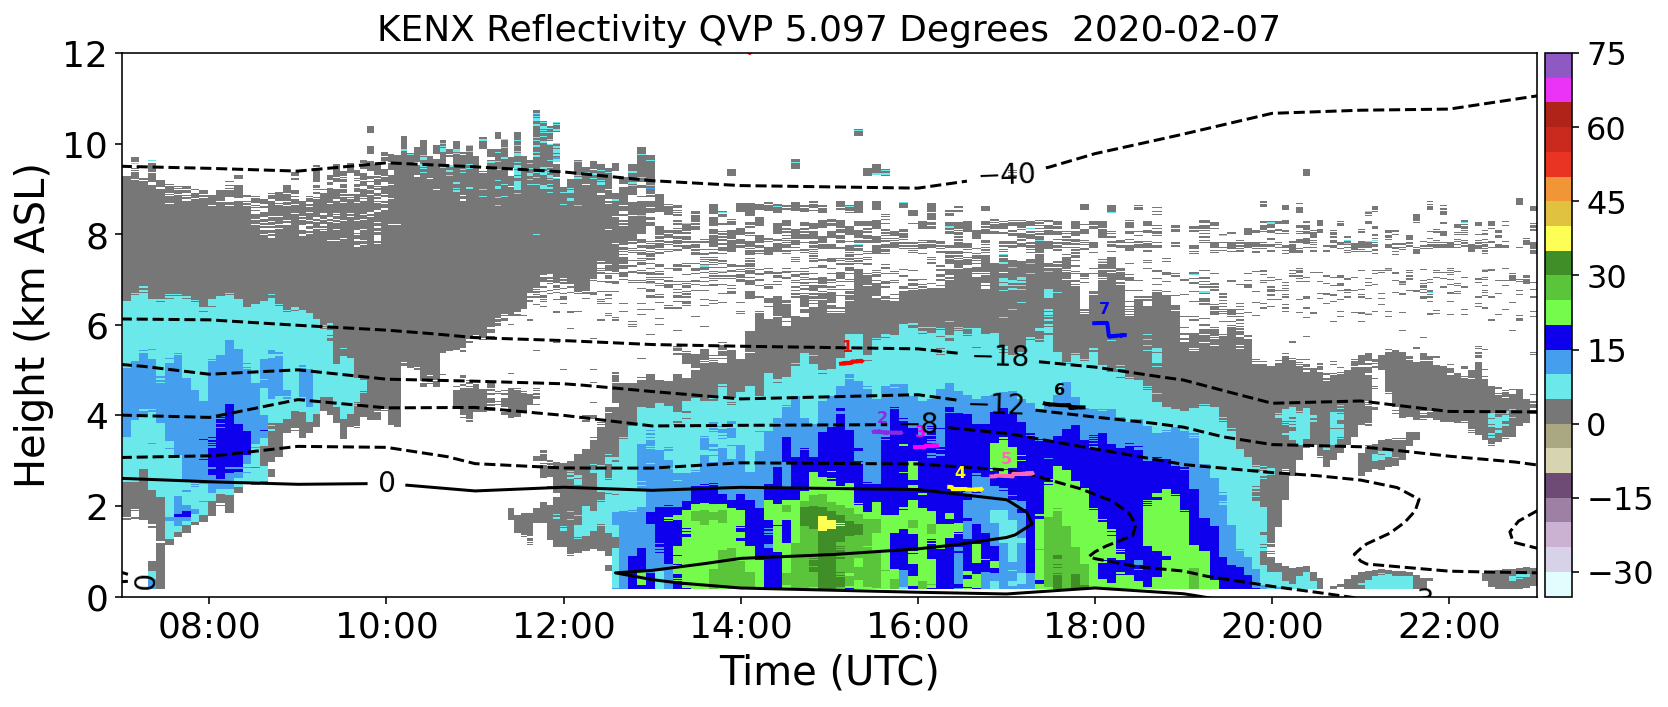

In [436]:
#Reflectivity QVP
ymin = 0
ymax = 12

cmap_reflectivity = mpl.colors.ListedColormap(['#e3fdfe','#d7d2e7','#cbb1d2','#9d80a4','#6d4b74','#d6d4b1','#a9a882','#777777','#6be9ea','#469eef','#0e00ec','#75fb4c','#5ac53a','#3f8e27','#feff54','#e1c140','#f09636','#ea3423','#ca2A1d','#b02318','#ea33f7','#8f59c3'])
bounds_reflectivity = [-35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
norm_reflectivity = mpl.colors.BoundaryNorm(bounds_reflectivity, cmap_reflectivity.N)

plt.figure(figsize = (15, 5))
cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T, cmap=cmap_reflectivity, norm = norm_reflectivity)
print(type(times_modified.loc[:, 0][0]))
plt.ylabel('Height (km ASL)', fontsize = 20)
plt.xlabel('Time (UTC)', fontsize = 20)
plt.title(ID + ' Reflectivity QVP '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
cbar = plt.colorbar(cs, pad=0.005)
cbar.ax.tick_params(labelsize = 16)
xformatter = md.DateFormatter('%H:%M')
xlocator = md.MinuteLocator(byminute=[0])
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
plt.gca().clabel(clabels, fontsize = 14)
plt.tick_params(labelsize = 18)
plt.ylim(ymin, ymax)


x_lower = plt.gca().get_xlim()[0]
plt.plot(tds_time,tds_alt,linewidth=2,color='red')
x_upper = plt.gca().get_xlim()[-1]
colors = ['red','blueviolet','magenta','yellow','hotpink','black','blue']
for i in range(len(flight_leg_date_ranges)):
    plt.plot(flight_leg_date_ranges[i],flight_leg_altitudes[i],color=colors[i],linewidth=2)
    txt = str(i+1)

    x1 = flight_leg_date_ranges[i][len(flight_leg_date_ranges[i])//2] 
    x = (md.date2num(pd.Timestamp.to_datetime64(x1)) - x_lower - .005) / (x_upper - x_lower) 
    y = (max(flight_leg_altitudes[i])+ .2)/ymax
    plt.text(x, y, txt, fontsize=8,weight = 'bold',color=colors[i],transform=plt.gca().transAxes)

plt.show()


# prior_alt = 0
# inflections = np.array([])
# i = 0
# for time,alt in zip(tds_time,tds_alt):
#     if alt < prior_alt:
#         inflections = np.append(inflections,np.array([i,time,alt]))
#     prior_alt = alt
#     i+=1


# inflections = inflections.reshape(int(len(inflections)/3),3)

# #plt.scatter(inflections[:,1],inflections[:,2]/1000,marker = '.',s=.01,color='blue')

# indices = np.arange(0,len(tds_alt),1)
# x = zip(indices,tds_time,tds_alt)
# x = np.array(list(x))
# i = np.array(np.where(abs(np.diff(tds_alt)) > 4)[0])

# #plt.scatter(np.array(tds_time)[i],np.array(tds_alt)[i]/1000,color='white')
# sorted_i = np.sort(np.diff(i))


# x_subset_indices = np.array(np.where(abs(np.diff(x[:,2])) > 4)[0])

# x_subset = x[x_subset_indices]

# x_diff = np.diff(x_subset,axis=0)


# x_subset[:,0][0:-1] = x_diff[:,0]
# x_subset = x_subset[:-1]
# f = np.sort(x_subset, axis = 0)[::-1]
# #plt.scatter(f[:,1][:20],f[:,2][:20]/1000)

In [ ]:
plt.figure(figsize=(15,5))
print(type(

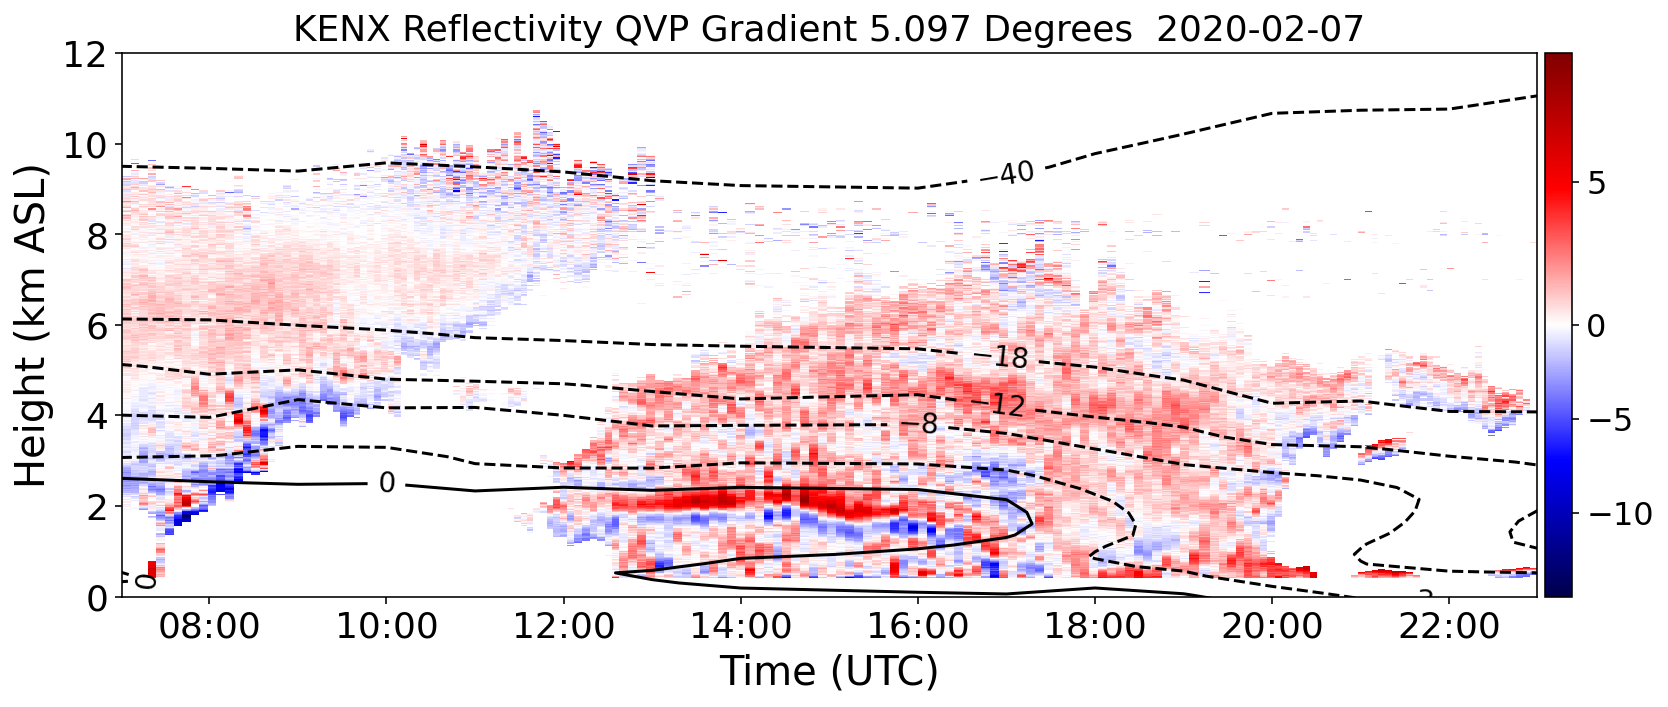

In [89]:
plt.figure(figsize = (15, 5))
z = reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T.diff(10, axis = 0) * -1
norm = mcolors.TwoSlopeNorm(vmin=min(z.min()), vcenter=0, vmax=max(z.max()))
cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, z, norm = norm, cmap='seismic')
plt.ylabel('Height (km ASL)', fontsize = 20)
plt.xlabel('Time (UTC)', fontsize = 20)
plt.title(ID + ' Reflectivity QVP Gradient '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
cbar = plt.colorbar(cs, pad=0.005)
cbar.ax.tick_params(labelsize = 16)
xformatter = md.DateFormatter('%H:%M')
xlocator = md.MinuteLocator(byminute=[0])
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.tick_params(labelsize = 18)
plt.ylim(ymin, ymax)
clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
plt.gca().clabel(clabels, fontsize = 14)
plt.show()

0.001388888888888889 0 36.66111111111111


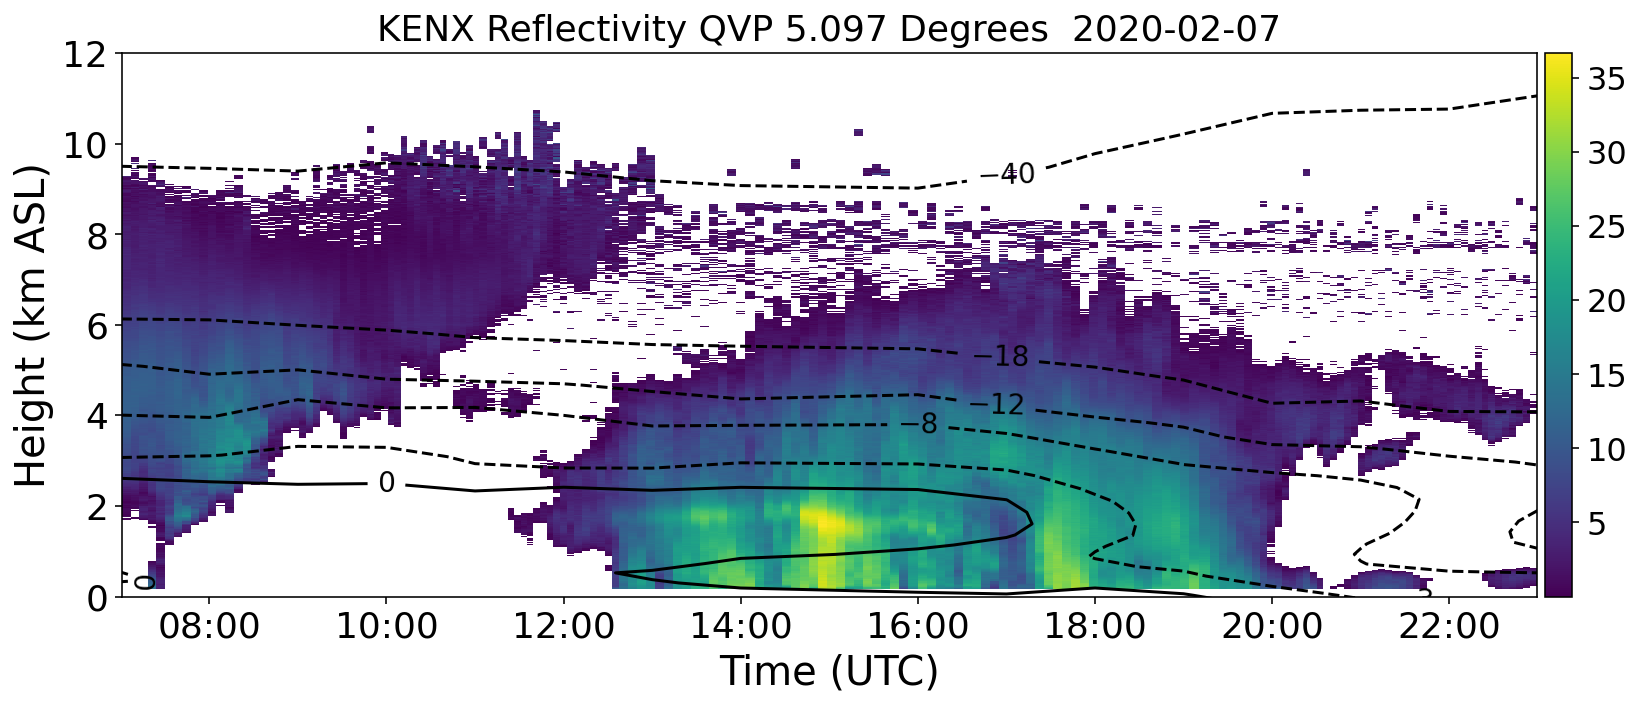

In [90]:
ymin = 0
ymax = 12



z = reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T
print(min(z.min()),0,max(z.max()))

plt.figure(figsize = (15, 5))
cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000,z, cmap='viridis', vmin = min(z.min()),vmax = max(z.max()))
plt.ylabel('Height (km ASL)', fontsize = 20)
plt.xlabel('Time (UTC)', fontsize = 20)
plt.title(ID + ' Reflectivity QVP '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
cbar = plt.colorbar(cs, pad=0.005)
cbar.ax.tick_params(labelsize = 16)
xformatter = md.DateFormatter('%H:%M')
xlocator = md.MinuteLocator(byminute=[0])
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
plt.gca().clabel(clabels, fontsize = 14)
plt.tick_params(labelsize = 18)
plt.ylim(ymin, ymax)
plt.show()

0.001388888888888889 0 36.66111111111111


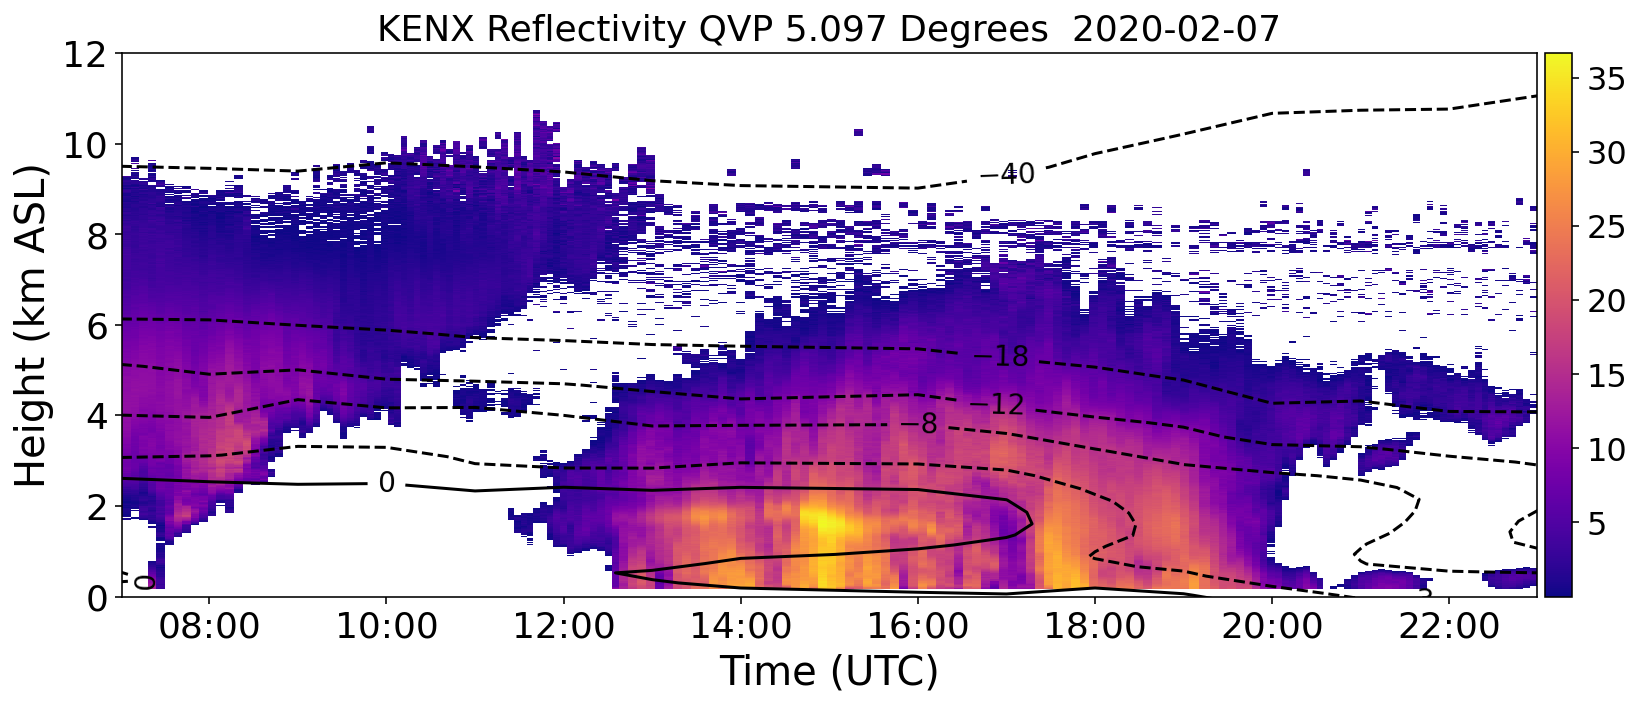

In [93]:
z = reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T

plt.figure(figsize = (15, 5))
cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000,z, cmap='plasma', vmin = min(z.min()),vmax = max(z.max()))
plt.ylabel('Height (km ASL)', fontsize = 20)
plt.xlabel('Time (UTC)', fontsize = 20)
plt.title(ID + ' Reflectivity QVP '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
cbar = plt.colorbar(cs, pad=0.005)
cbar.ax.tick_params(labelsize = 16)
xformatter = md.DateFormatter('%H:%M')
xlocator = md.MinuteLocator(byminute=[0])
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
plt.gca().clabel(clabels, fontsize = 14)
plt.tick_params(labelsize = 18)
plt.ylim(ymin, ymax)
plt.show()

0.0014084507042253522 0 36.66111111111111


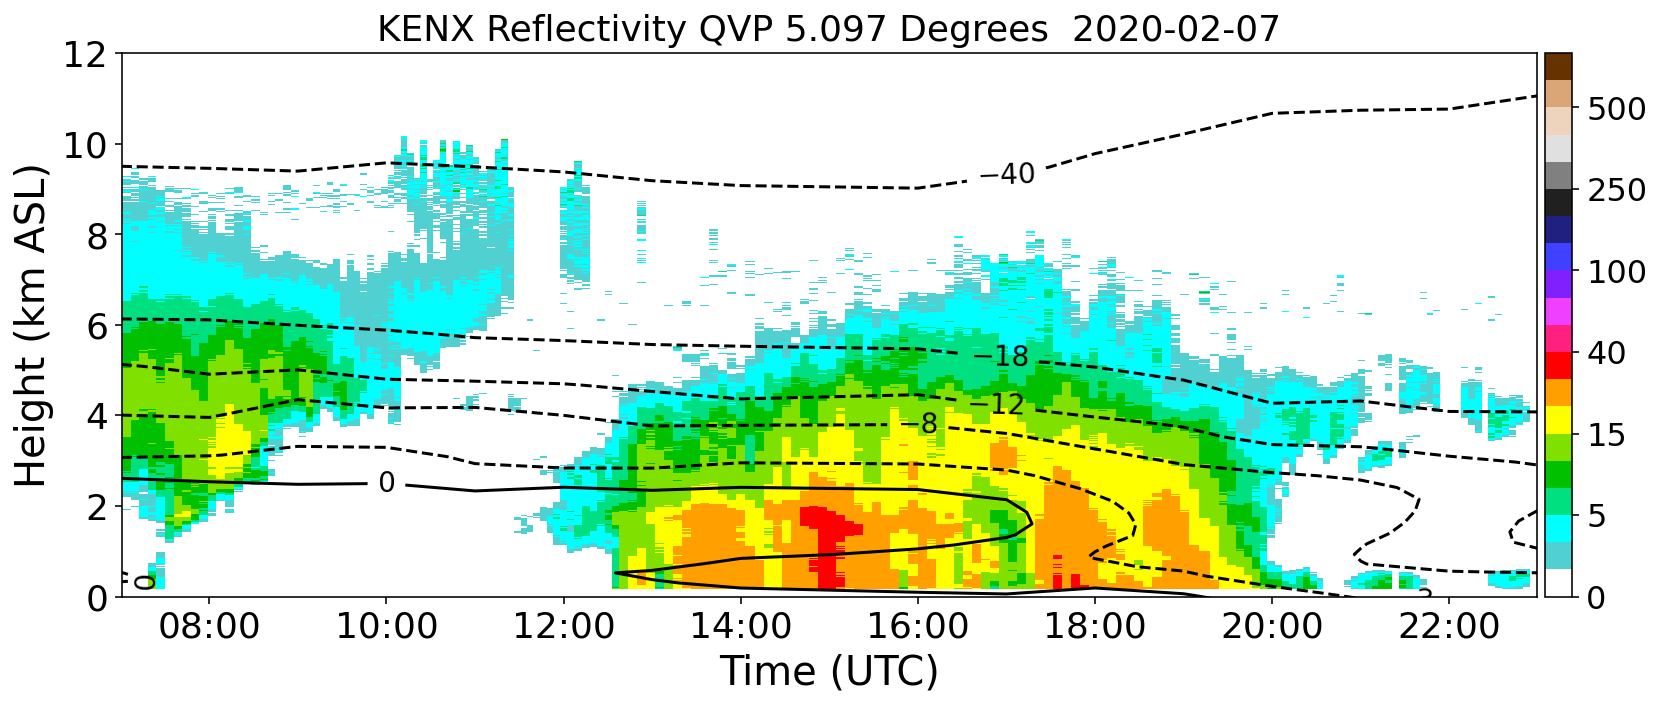

In [94]:
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

z = reflectivities_deep[(s>200) & (reflectivities_deep > 0)].T
print(min(z.min()),0,max(z.max()))

plt.figure(figsize = (15, 5))
cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000,z, cmap=cmap,norm=norm)
plt.ylabel('Height (km ASL)', fontsize = 20)
plt.xlabel('Time (UTC)', fontsize = 20)
plt.title(ID + ' Reflectivity QVP '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
cbar = plt.colorbar(cs, pad=0.005)
cbar.ax.tick_params(labelsize = 16)
xformatter = md.DateFormatter('%H:%M')
xlocator = md.MinuteLocator(byminute=[0])
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
plt.gca().clabel(clabels, fontsize = 14)
plt.tick_params(labelsize = 18)
plt.ylim(ymin, ymax)
plt.show()

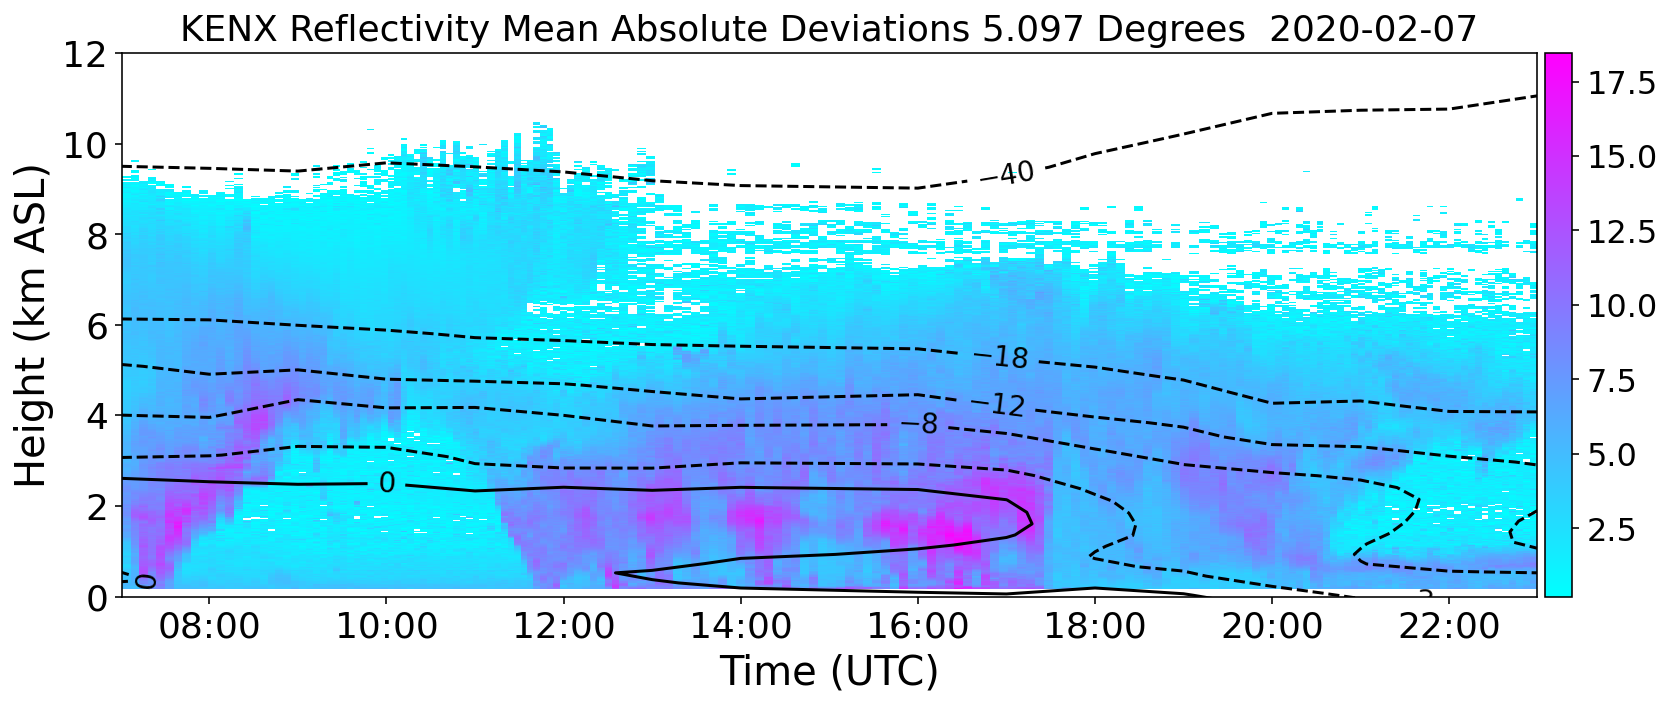

In [95]:

#Reflectivity MAD
plt.figure(figsize = (15, 5))
z = reflectivities_mad_deep[(s>5) & (reflectivities_mad_deep > 0)].T
zmin = min(z.min())
zmax = max(z.max())
cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, z, cmap='cool',vmin = zmin,vmax=zmax)
plt.ylabel('Height (km ASL)', fontsize = 20)
plt.xlabel('Time (UTC)', fontsize = 20)
plt.title(ID + ' Reflectivity Mean Absolute Deviations '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
cbar = plt.colorbar(cs, pad=0.005)
cbar.ax.tick_params(labelsize = 16)
xformatter = md.DateFormatter('%H:%M')
xlocator = md.MinuteLocator(byminute=[0])
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.tick_params(labelsize = 18)
plt.ylim(ymin, ymax)
clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
plt.gca().clabel(clabels, fontsize = 14)

plt.show()



22


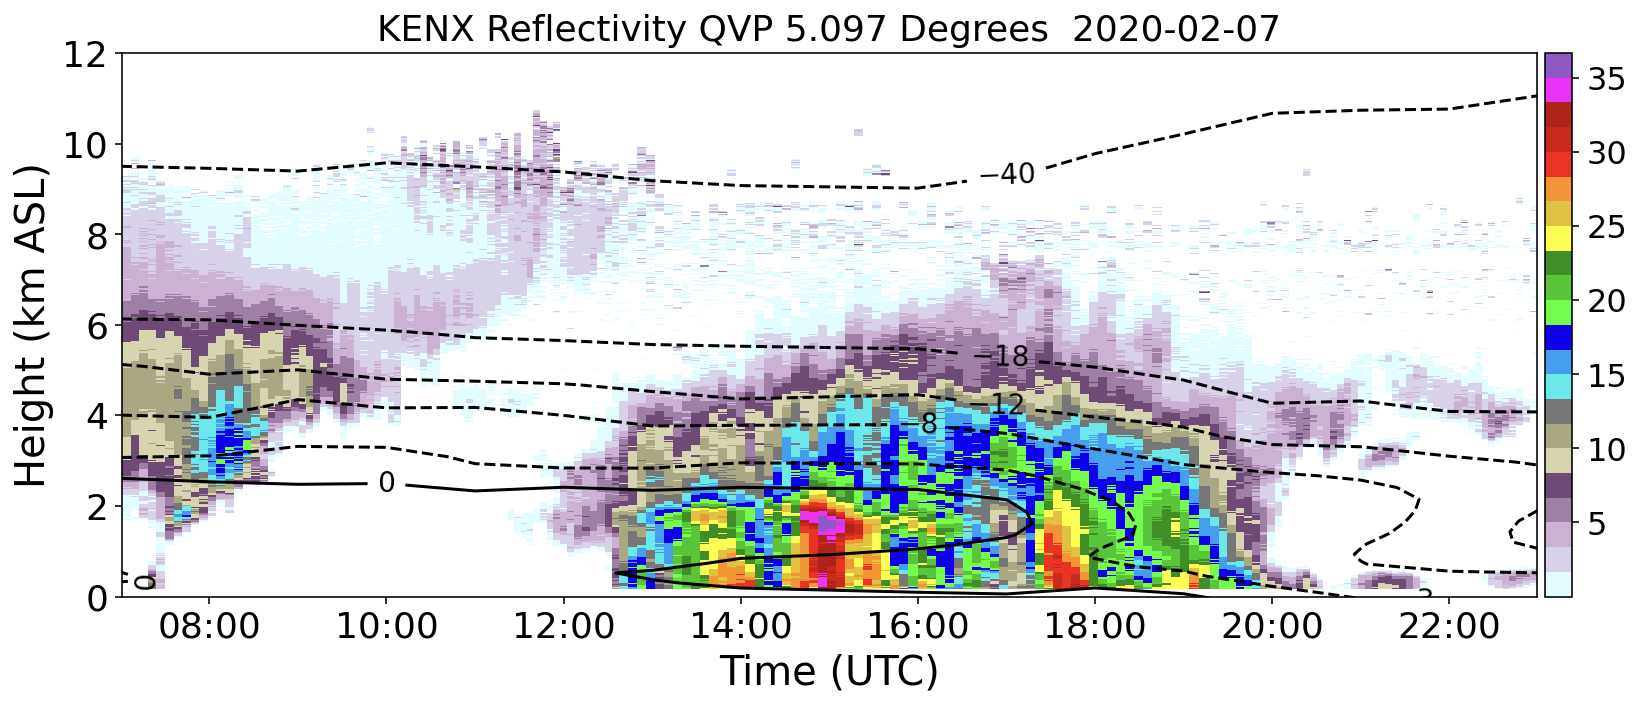

In [96]:
cmap_reflectivity = mpl.colors.ListedColormap(['#e3fdfe','#d7d2e7','#cbb1d2','#9d80a4','#6d4b74','#d6d4b1','#a9a882','#777777','#6be9ea','#469eef','#0e00ec','#75fb4c','#5ac53a','#3f8e27','#feff54','#e1c140','#f09636','#ea3423','#ca2A1d','#b02318','#ea33f7','#8f59c3'])
print(cmap_reflectivity.N)
z = reflectivities_deep[(s>5) & (reflectivities_deep > 0)].T
zmin = min(z.min())
zmax = max(z.max())
bounds_reflectivity = [zmin,zmax]
norm_reflectivity = mpl.colors.BoundaryNorm(bounds_reflectivity,ncolors= 256)
plt.figure(figsize = (15, 5))
cs = plt.pcolormesh(times_modified.loc[:, 0], heights.loc[0, :].T/1000, z, cmap=cmap_reflectivity,vmin=zmin,vmax=zmax)
plt.ylabel('Height (km ASL)', fontsize = 20)
plt.xlabel('Time (UTC)', fontsize = 20)
plt.title(ID + ' Reflectivity QVP '+ str(closestAngle)[:-5] + ' Degrees ' + EVENT_DATE, fontsize = 18)
cbar = plt.colorbar(cs, pad=0.005)
cbar.ax.tick_params(labelsize = 16)
xformatter = md.DateFormatter('%H:%M')
xlocator = md.MinuteLocator(byminute=[0])
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
clabels = plt.gca().contour(np.array(times_all)[:,radarIdx], np.array(gps_all)[:,radarIdx]/1000, np.array(temps_all)[:,radarIdx], colors = 'black', levels = [-40, -18, -12, -8, -3, 0])
plt.gca().clabel(clabels, fontsize = 14)
plt.tick_params(labelsize = 18)
plt.ylim(ymin, ymax)
plt.show()